# Day 15 - maze exploration

- https://adventofcode.com/2019/day/15

We've dealt with mazes before; it was a major theme in 2016 (days [13](../2016/puzzle13.py), [17](../2016/puzzle17.py) and [24](../2016/puzzle24.py)) but we were given a map for those mazes.

So we'll first have to build the map; the best method for that is to always [follow the wall](https://en.wikipedia.org/wiki/Maze_solving_algorithm#Wall_follower), keeping the wall to your left- or right-hand side. I'm keeping the wall to the left.

Once the oxygen location is found, we need to measure the shortest path from the start to that point. That's a [path finding problem](https://en.wikipedia.org/wiki/Pathfinding), and I've retooled the [A\* search algorithm](https://en.wikipedia.org/wiki/Pathfinding#A*_algorithm) implementation I had used before. In fact, a lot of the code for part 1 was basically re-used from previous challenges; displaying the maze as PIL image as we explore it is basically a copy-and-paste job from the [breakout game from day 13](./Day%2013.ipynb).


In [1]:
from __future__ import annotations

from collections import deque
from dataclasses import dataclass, field
from enum import Enum
from heapq import heapify, heappop, heappush
from io import BytesIO
from itertools import count
from typing import (
    TYPE_CHECKING,
    ContextManager,
    Deque,
    Dict,
    Generator,
    Generic,
    Iterator,
    List,
    MutableMapping,
    NamedTuple,
    Optional,
    Tuple,
    Type,
    TypeVar,
)

from IPython.display import DisplayHandle, display
from PIL import Image, ImageDraw
from PIL.ImagePalette import ImagePalette

from intcode import CPU, Instruction, InstructionSet, base_opcodes

T = TypeVar("T")


class PriorityQueue(Generic[T]):
    def __init__(self, *initial: Tuple[int, T]) -> None:
        self._queue: List[Tuple[int, int, T]] = []
        self._count = count()
        for pri, item in initial:
            self.put(pri, item)
        heapify(self._queue)

    def __len__(self) -> int:
        return len(self._queue)

    def put(self, pri: int, item: T) -> None:
        heappush(self._queue, (pri, next(self._count), item))

    def get(self) -> T:
        if not self:
            raise ValueError("Queue is empty")
        return heappop(self._queue)[-1]


class Pos(NamedTuple):
    x: int = 0
    y: int = 0

    def __mul__(self, factor: int) -> Pos:
        if isinstance(factor, int):
            return self._replace(x=self.x * factor, y=self.y * factor)
        return NotImplemented

    def __add__(self, other: Pos) -> Pos:  # type: ignore
        if isinstance(other, Pos):
            return self._replace(x=self.x + other.x, y=self.y + other.y)
        return NotImplemented

    def __sub__(self, other: Pos) -> Pos:
        if isinstance(other, Pos):
            return self._replace(x=self.x - other.x, y=self.y - other.y)
        return NotImplemented

    def __abs__(self) -> Pos:
        return self._replace(x=abs(self.x), y=abs(self.y))

    def offset(self, minx: int, miny: int) -> Pos:
        return self._replace(x=self.x - minx, y=self.y - miny)


POS0 = Pos()


class Direction(Enum):
    # value, left, right, move delta
    north = 1, "west", "east", Pos(0, -1)
    south = 2, "east", "west", Pos(0, 1)
    west = 3, "south", "north", Pos(-1, 0)
    east = 4, "north", "south", Pos(1, 0)

    if TYPE_CHECKING:
        _left: str
        _right: str
        _delta: Pos

    def __new__(
        self,
        value: int,
        left: Optional[str] = None,
        right: Optional[str] = None,
        delta: Optional[Pos] = None,
    ) -> Direction:
        self = object.__new__(self)
        self._value_ = value
        assert left is not None
        assert right is not None
        assert delta is not None
        self._left = left
        self._right = right
        self._delta = delta
        return self

    @property
    def left(self) -> Direction:
        return Direction[self._left]

    @property
    def right(self) -> Direction:
        return Direction[self._right]

    def move(self, pos: Pos) -> Pos:
        return pos + self._delta


class MazeTile(Enum):
    unknown = -1
    wall = 0
    path = 1
    oxygen = 2

    def put(self, draw: ImageDraw.Draw, pos: Pos) -> None:
        # colour is value + 1
        colour = self.value + 1
        _rect_at(draw, pos, colour)


PALETTE: ImagePalette = ImagePalette(
    "RGB",
    [
        v
        for c in (
            (0x00, 0x00, 0x00),  # black, unknown tile
            (0xC0, 0xC0, 0xC0),  # silver, wall
            (0xFF, 0xFF, 0xFF),  # white, path
            (0x64, 0x95, 0xED),  # cornflowerblue, oxygen
            (0xFF, 0x45, 0x00),  # orangered, current position
            (0x00, 0xFF, 0xFF),  # aqua, part 2
        )
        for v in c
    ],
)
SCALE = 12
CURRENT_COLOUR = 4


def _rect_at(draw: ImageDraw.Draw, pos: Pos, colour: int) -> None:
    topleft = pos * SCALE
    bottomright = topleft + Pos(SCALE, SCALE)
    draw.rectangle((topleft, bottomright), colour)


@dataclass
class MazeMap(MutableMapping[Pos, MazeTile]):
    _tiles: Dict[Pos, MazeTile] = field(default_factory=dict)
    _xrange: range = range(0)
    _yrange: range = range(0)
    _pos: Pos = Pos()
    _image: Optional[Image.Image] = None
    _draw: Optional[ImageDraw.Draw] = None

    def _create_image(self, width: int, height: int) -> Image.Image:
        self._image = img = Image.new("P", (width, height))
        self._draw = draw = ImageDraw.Draw(img)
        img.putpalette(PALETTE)
        return img, draw

    def _update_image(
        self, pos: Optional[Pos] = None, tile: Optional[MazeTile] = None
    ) -> None:
        old = self._xrange, self._yrange
        if pos is not None:
            x, y = pos
            if x < self._xrange.start:
                self._xrange = range(x, self._xrange.stop)
            elif x >= self._xrange.stop:
                self._xrange = range(self._xrange.start, x + 1)
            if y < self._yrange.start:
                self._yrange = range(y, self._yrange.stop)
            elif y >= self._yrange.stop:
                self._yrange = range(self._yrange.start, y + 1)
        else:
            self._xrange = range(
                min(x for x, _ in self._tiles),
                max(x for x, _ in self._tiles) + 1,
            )
            self._yrange = range(
                min(y for _, y in self._tiles),
                max(y for _, y in self._tiles) + 1,
            )

        if (self._xrange, self._yrange) != old:
            minx, miny = self._xrange.start, self._yrange.start
            W, H = len(self._xrange) * SCALE, len(self._yrange) * SCALE
            img, draw = self._create_image(W, H)
            for pos, tile in self._tiles.items():
                tile.put(draw, pos.offset(minx, miny))
            self.update_pos(self._pos)
        elif pos is not None and tile is not None:
            tile.put(self._draw, pos.offset(self._xrange.start, self._yrange.start))

    def update_pos(self, pos: Pos) -> None:
        draw = self._draw
        if draw is not None and pos != self._pos and self._pos in self._tiles:
            self._tiles[self._pos].put(
                draw, self._pos.offset(self._xrange.start, self._yrange.start)
            )
        self._pos = pos
        if draw is not None:
            _rect_at(
                draw, pos.offset(self._xrange.start, self._yrange.start), CURRENT_COLOUR
            )

    def __iter__(self) -> Iterator[Pos]:
        return iter(self._tiles)

    def __len__(self) -> int:
        return len(self._tiles)

    def __getitem__(self, pos: Pos) -> MazeTile:
        return self._tiles.get(pos, MazeTile.unknown)

    def __setitem__(self, pos: Pos, tile: MazeTile) -> None:
        if pos in self._tiles:
            assert tile in {MazeTile.unknown, self._tiles[pos]}
            if tile is not MazeTile.unknown:
                return

        if tile is MazeTile.unknown:
            self._tiles.pop(pos, None)
            self._update_image()
            if pos.x in self._xrange and pos.y in self._yrange:
                MazeTile.unknown.put(self._draw, pos)
        else:
            self._tiles[pos] = tile
            self._update_image(pos, tile)

    def __delitem__(self, pos: Pos) -> None:
        del self._tiles[pos]
        self._update_image()
        if self._draw is not None and pos.x in self._xrange and pos.y in self._yrange:
            MazeTile.unknown.put(self._draw, pos)

    def _repr_png_(self) -> bytes:
        img = self._image
        if img is None:
            img = Image.new("P", (1, 1))
        f = BytesIO()
        img.save(f, "PNG")
        return f.getvalue()


@dataclass(frozen=True)
class MazeState:
    pos: Pos
    steps: int = field(default=0, compare=False)

    def moves(self, map: MazeMap):
        for direction in Direction:
            pos = direction.move(self.pos)
            if map[pos] not in {MazeTile.wall, MazeTile.unknown}:
                yield MazeState(pos, self.steps + 1)

    def heuristic(self, target):
        return sum(abs(self.pos) - abs(target.pos)) + self.steps


class ReachedPOI(Exception):
    pass


class OxygenFound(ReachedPOI):
    pass


class CompletedMaze(ReachedPOI):
    pass


RemoteRobotRunner = Generator[None, int, None]


class MazeExplorer(ContextManager[RemoteRobotRunner]):
    maze_map: MazeMap
    control_queue: Deque[int]
    ogygen: Optional[Pos] = None
    _runner: Optional[RemoteRobotRunner] = None
    _display_handle: DisplayHandle

    def __init__(self, control_queue: Deque[int]):
        self.maze_map = MazeMap()
        self.control_queue = control_queue
        self._display_handle = display(self, display_id=True)

    def update_display(self) -> None:
        self._display_handle.update(self)

    def found_oxygen(self, pos: Pos) -> None:
        self.oxygen = pos
        raise OxygenFound

    def completed_maze_exploration(self) -> None:
        raise CompletedMaze

    def powerdown(self) -> None:
        if self._runner is not None:
            self._runner.close()
            self._runner = None

    def __enter__(self) -> RemoteRobotRunner:
        if self._runner is None:
            self._runner = self.run()
            # prime the runner, so it is waiting for input
            next(self._runner)
        return self._runner

    def __exit__(self, *exc) -> None:
        self.powerdown()

    def run(self) -> Generator[None, int, None]:
        queue = self.control_queue
        map = self.maze_map
        pos: Pos = Pos()
        map[pos] = MazeTile.path
        direction = Direction.north

        while True:
            # 1. make move(s)

            # first check if we already know about walls in the
            # prospective new position, no point in wasting
            # remote robot cycles for those.
            new_pos = direction.move(pos)
            while map[new_pos] is MazeTile.wall:
                # wall ahead? Keep it to our left
                direction = direction.right
                new_pos = direction.move(pos)

            # send move instruction, see if there is a path here
            queue.append(direction.value)

            # 2. receive status

            tile = MazeTile((yield None))

            # 3. update our map and possibly our position,
            # decide on next move.

            map[new_pos] = tile
            if tile is MazeTile.wall:
                # wall ahead? Keep it to our left
                direction = direction.right
            else:
                if tile is MazeTile.oxygen:
                    # signal that we found the oxygen
                    self.found_oxygen(new_pos)

                # can move straight, step then turn left to ensure we see a wall.
                pos = new_pos
                map.update_pos(pos)
                direction = direction.left

                if pos == Pos():
                    self.completed_maze_exploration()

            self.update_display()

    def find_shortest_path(self, target: Pos, start: Pos = POS0) -> None:
        startstate = MazeState(start)
        goal = MazeState(target)
        map = self.maze_map
        queue: PriorityQueue[MazeState] = PriorityQueue(
            (startstate.heuristic(goal), startstate)
        )
        open_ = {startstate: 0}
        closed = set()

        while open_:
            current = queue.get()
            if open_.get(current) != current.steps:
                # ignore items in the queue for which a shorter
                # path exists
                continue

            if current == goal:
                return current.steps

            del open_[current]
            closed.add(current)
            for neighbor in current.moves(map):
                if neighbor in closed:
                    continue
                if neighbor.steps >= open_.get(neighbor, float("inf")):
                    # not a shorter path than we already have
                    continue
                open_[neighbor] = neighbor.steps
                queue.put(neighbor.heuristic(goal), neighbor)

    def _repr_png_(self) -> bytes:
        return self.maze_map._repr_png_()


M = TypeVar("M", bound=MazeExplorer)


def direct_explorer(memory: List[int], explorer_type: Type[M] = MazeExplorer) -> M:
    inputqueue = deque()
    explorer = explorer_type(inputqueue)
    with explorer as runner:
        opcodes: InstructionSet = {
            **base_opcodes,
            3: Instruction(inputqueue.popleft, output=True),
            4: Instruction(runner.send, 1),
        }
        try:
            CPU(opcodes).reset(memory).execute()
        except ReachedPOI:
            pass
    return explorer


def find_oxygen(memory: List[int]) -> int:
    explorer = direct_explorer(memory)
    assert explorer.oxygen is not None
    return explorer.find_shortest_path(explorer.oxygen)

In [2]:
import aocd

data = aocd.get_data(day=15, year=2019)
memory = list(map(int, data.split(",")))

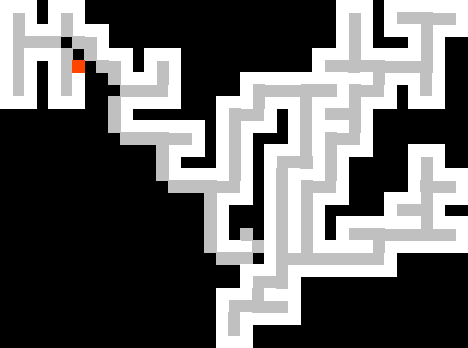

Part 1: 266


In [3]:
print("Part 1:", find_oxygen(memory))

## Part 2 - full maze

For part two, we need to explore all of the maze, so we can use a full search across all possible positions to find how many steps (or minutes) it takes to reach the furthest position from the repaired oxygen output.

This is actually simpler than part 1; all we have to do is wait for our maze explorer to reach the starting position again. Finding the longest path is as simple as adding possible next moves to a queue, and repeating this procedure until we run out of places we haven't visited yet.


In [4]:
class OxygenatingMazeExplorer(MazeExplorer):
    def found_oxygen(self, pos: Pos) -> None:
        self.oxygen = pos

    def find_longest_path(self, start: Pos) -> int:
        queue = deque([MazeState(start)])
        visited = set([start])
        map = self.maze_map

        maxlength = 0

        while queue:
            current = queue.popleft()
            for neighbor in current.moves(map):
                if neighbor in visited:
                    continue
                maxlength = max(maxlength, neighbor.steps)
                visited.add(neighbor)
                queue.append(neighbor)

                # visualise the oxygen flood
                if neighbor.pos != Pos():
                    pos = neighbor.pos.offset(map._xrange.start, map._yrange.start)
                    _rect_at(map._draw, pos, 5)
                    self.update_display()

        return maxlength


def time_oxygen_release(memory: List[int]) -> int:
    explorer = direct_explorer(memory, OxygenatingMazeExplorer)

    assert explorer.oxygen is not None
    return explorer.find_longest_path(explorer.oxygen)

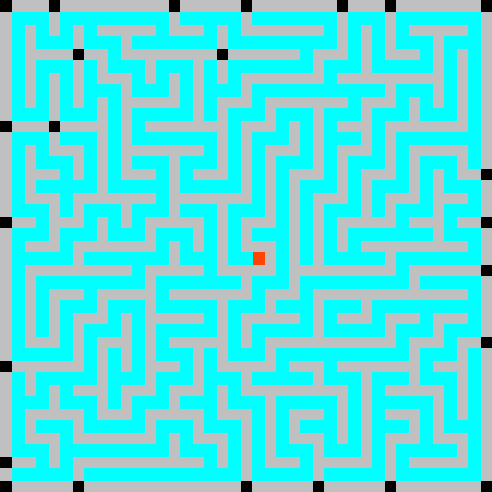

Part 2: 274


In [5]:
print("Part 2:", time_oxygen_release(memory))